# Test method `compute_heatmap`

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
from datetime import datetime
from glob import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Project
import sys
sys.path.append(os.path.join(os.path.abspath(os.path.dirname('.')), '..', 'common'))

import matplotlib.pylab as plt
%matplotlib inline

def plt_st(n, m):
    plt.figure(figsize=(n, m))
    
from training_utils import find_best_weights_file2

Using Theano backend.


In [3]:
sys.path.append(os.path.join(os.path.abspath(os.path.dirname('.')), '..', 'common/KerasSqueezeNet'))
from keras_squeezenet.squeezenet import SqueezeNet    

val_fold_index = 0
optimizer = 'adam'
seed = 2017
load_best_weights = True

save_prefix='squeezenet_v2_cervix_normal_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
cnn = SqueezeNet(input_shape=(299, 299, 3), classes=3, include_top=False)

if load_best_weights:
    weights_files = glob("../notebooks/weights/%s*.h5" % save_prefix)
    if len(weights_files) > 0:
        best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
        print("Load best loss weights: ", best_weights_filename, best_val_loss)
        cnn.load_weights(best_weights_filename)

Load best loss weights:  ../notebooks/weights/squeezenet_v2_cervix_normal_cvfold=0_opt=adam_seed=2017_38_val_loss=0.8098_val_acc=0.6457_val_precision=0.7188_val_recall=0.5382.h5 0.8098


In [13]:
# from vgg16_keras122 import get_vgg16

# load_best_weights = True

# save_prefix='vgg16_finetunning_blocks345_cervix_normal_opt=adam_seed=54321'
# cnn = get_vgg16(image_size=(224, 224))

# if load_best_weights:
#     weights_files = glob("../notebooks/weights/%s*.h5" % save_prefix)
#     if len(weights_files) > 0:
#         best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
#         print("Load best loss weights: ", best_weights_filename, best_val_loss)
#         cnn.load_weights(best_weights_filename)

('Load best loss weights: ', '../notebooks/weights/vgg16_finetunning_blocks345_cervix_normal_opt=adam_seed=54321_37_val_loss=0.6949_val_acc=0.6803_val_precision=0.7486_val_recall=0.5984.h5', 0.6949)


In [4]:
from data_utils import GENERATED_DATA
print("\n {} - Get train/val lists ...".format(datetime.now()))

trainval_normal_id_type_list = np.load(os.path.join(GENERATED_DATA, 'normal_id_type_list.npz'))['normal_id_type_list'].astype(np.str)
len(trainval_normal_id_type_list), trainval_normal_id_type_list[0]


 2017-05-14 11:42:01.505700 - Get train/val lists ...


(4977, array(['209', 'AType_2'], 
       dtype='<U7'))

In [5]:
from xy_providers import DataCache
try:
    if cache is None:
        cache = DataCache(0)
except NameError:
    cache = DataCache(0)

In [8]:
batch_size = 1
from data_utils import GENERATED_DATA
from image_utils import scale_percentile
from xy_providers import cached_image_label_provider
from preprocessing.image.generators import ImageDataGenerator
from visu_utils import compute_heatmap

normalize_data = True
image_size = (299, 299)
channels_first = False

xy_provider = cached_image_label_provider
val_gen = ImageDataGenerator(featurewise_center=normalize_data,
                             featurewise_std_normalization=normalize_data)

if normalize_data:
    val_gen.std = 1.0 / 255.0  # Rescale to [0.0, 255.0]
    m = np.array([123.68, 116.779, 103.939]) / 255.0 # RGB
    if channels_first:                
        m = m[:, None, None]
    else:
        m = m[None, None, :]
    val_gen.mean = m   
        
          
flow = val_gen.flow(xy_provider(trainval_normal_id_type_list,
                                image_size=image_size,
                                option='cervix',
                                channels_first=channels_first,
                                cache=cache,
                                test_mode=True),
                    # Ensure that all batches have the same size
                    len(trainval_normal_id_type_list),
                    batch_size=batch_size)
total_counter = 0

In [9]:
_to_data_format = lambda image : image
if channels_first:
    _to_data_format = lambda image : image.transpose([1, 2, 0])

-- 6
('317', 'Type_2') [ 0.31322679  0.57360744  0.11316575] [0 1 0]
y_pred_0= [[ 0.31322679  0.57360744  0.11316575]]
top_class_indices= [1 0 2]


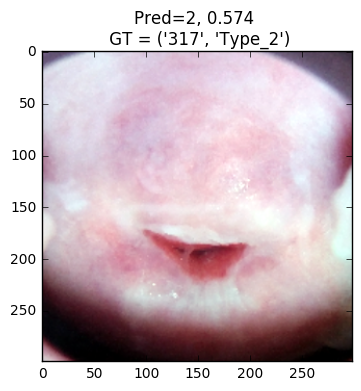

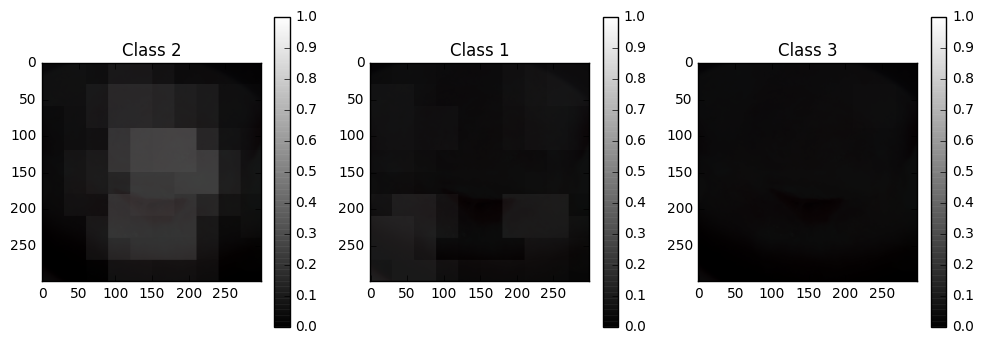

In [15]:
for x, y_true, info in flow:

    s = y_true.shape[0]

    y_pred = cnn.predict(x)
    print("--", total_counter*batch_size + s)    
    total_counter += 1
    plt_st(12, 4)
    for i in range(s):
        print(info[i], y_pred[i], y_true[i])
        plt.subplot(1, s, i+1)
        plt.title("Pred={}, {:.3f} \n GT = {}".format(np.argmax(y_pred[i])+1, np.max(y_pred[i]), info[i]))
        plt.imshow(scale_percentile(_to_data_format(x[i, :, :, :])))

    n_classes = y_true.shape[1]
    plt_st(12, 4)
    for i in range(s):
        hm, top_class_indices = compute_heatmap(cnn, x[i, :, :, :], mask_size=60, step=30, n_top_classes=None, batch_size=16)        
        for j in range(n_classes):
            plt.subplot(s, n_classes, n_classes * i + j + 1)            
            plt.title("Class {}".format(top_class_indices[j] + 1))
            plt.imshow(scale_percentile(_to_data_format(x[i, :, :, :])))        
            plt.imshow(hm[j, :, :], alpha=0.95, cmap='gray', vmin=0, vmax=1)
            plt.colorbar()

    break

('--', 24)
(('3584', 'AType_1'), array([  9.27875757e-01,   7.18665197e-02,   2.57744454e-04], dtype=float32), array([1, 0, 0], dtype=uint8))
('y_pred_0=', array([[  9.27875757e-01,   7.18665197e-02,   2.57744454e-04]], dtype=float32))
('top_class_indices=', array([0, 1, 2]))


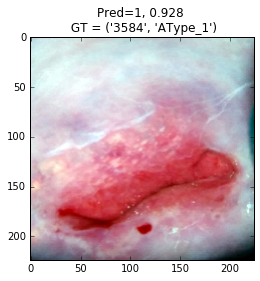

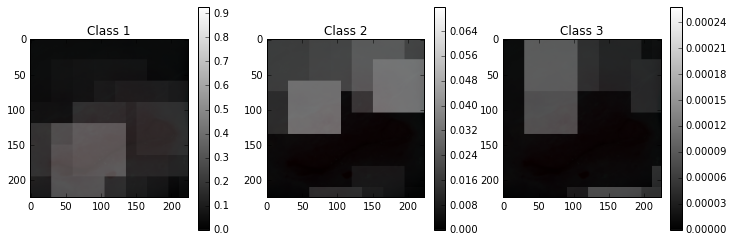

In [62]:
s = y_true.shape[0]

y_pred = cnn.predict(x)
print("--", total_counter*batch_size + s)    
total_counter += 1
plt_st(12, 4)
for i in range(s):
    print(info[i], y_pred[i], y_true[i])
    plt.subplot(1, s, i+1)
    plt.title("Pred={}, {:.3f} \n GT = {}".format(np.argmax(y_pred[i])+1, np.max(y_pred[i]), info[i]))
    plt.imshow(scale_percentile(_to_data_format(x[i, :, :, :])))

n_classes = y_true.shape[1]
plt_st(12, 4)
for i in range(s):
    hm, top_class_indices = compute_heatmap(cnn, x[i, :, :, :], mask_size=75, step=30, n_top_classes=None, batch_size=16)        
    for j in range(n_classes):
        plt.subplot(s, n_classes, n_classes * i + j + 1)            
        plt.title("Class {}".format(top_class_indices[j] + 1))
        plt.imshow(scale_percentile(_to_data_format(x[i, :, :, :])))        
        plt.imshow(hm[j, :, :], alpha=0.95, cmap='gray', vmin=0, vmax=1)
        plt.colorbar()

y_pred_0 = 0.71,  0.28,  0.01

**case 1**
img_0 -> img_0 + mask
=> y_pred_1 = 0.71,  0.28,  0.01
==> diff = 0, 0, 0
===> mask is insignificant

**case 2**
img_0 -> img_0 + mask
=> y_pred_1 = 0.68,  0.29,  0.03
==> diff = 0.03, -0.01, -0.02
===> mask lowers top predection and uppers others
====> diff = 0.03, 0, 0

**case 3**
img_0 -> img_0 + mask
=> y_pred_1 = 0.40,  0.25,  0.35
==> diff = 0.31, 0.03, -0.34
===> mask lowers top predection and uppers others
====> diff = 0.31, 0.03, 0




In [50]:
np.minimum(2 * np.ones((10, 10)), 3 * np.ones((10, 10)))

array([[ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.]])